In [1]:
import sys
sys.path.append('../utils/')
import torch
import torchvision
import numpy as np
import pylab as plt
import albumentations
from tqdm import tqdm
from datasets import ACDCDataset
from models import ENet

augmentation = albumentations.Compose([
    albumentations.Resize(256, 256),
    albumentations.CLAHE(p=1.),
])

dataset = ACDCDataset('../data/acdc/training', None, augmentation, preload=False)
test_dataset = ACDCDataset('../data/acdc/testing/testing', None, augmentation, preload=False, load_mask=False)
train_dataset, val_dataset = dataset.split_train_val(train_size=0.7)

In [2]:
device = torch.device('cuda:0') if torch.cuda.is_available() else torch.device('cpu')
unet_rn50 = torch.load('/Users/airplaneless/source/projects/medsegmentation/models/unet-resnet50/unet-resnet50.pth', map_location=device).eval()
unet_dn161 = torch.load('/Users/airplaneless/source/projects/medsegmentation/models/unet-densenet161/unet-densenet161.pth', map_location=device).eval()
enet = torch.load('/Users/airplaneless/source/projects/medsegmentation/models/enet-256/enet-256.pth', map_location=device).eval()

In [5]:
sum(p.numel() for p in unet_rn50.parameters())

32515268

In [45]:
def plot_pred(model, img, ax):
    with torch.no_grad():
        pred = model(img.unsqueeze(0).to(device))[0]
    probas = torch.nn.functional.softmax(pred, dim=0)
    pred_mask = np.zeros((256, 256))
    for i in [1,2,3]:
        pred_mask[np.where(probas[i].numpy() > 0.8)] = i
    ax.imshow(img.numpy()[0], cmap=plt.cm.gray)
    ax.imshow(pred_mask, alpha=0.4, cmap=plt.cm.jet)
    ax.set_xticks([])
    ax.set_yticks([])

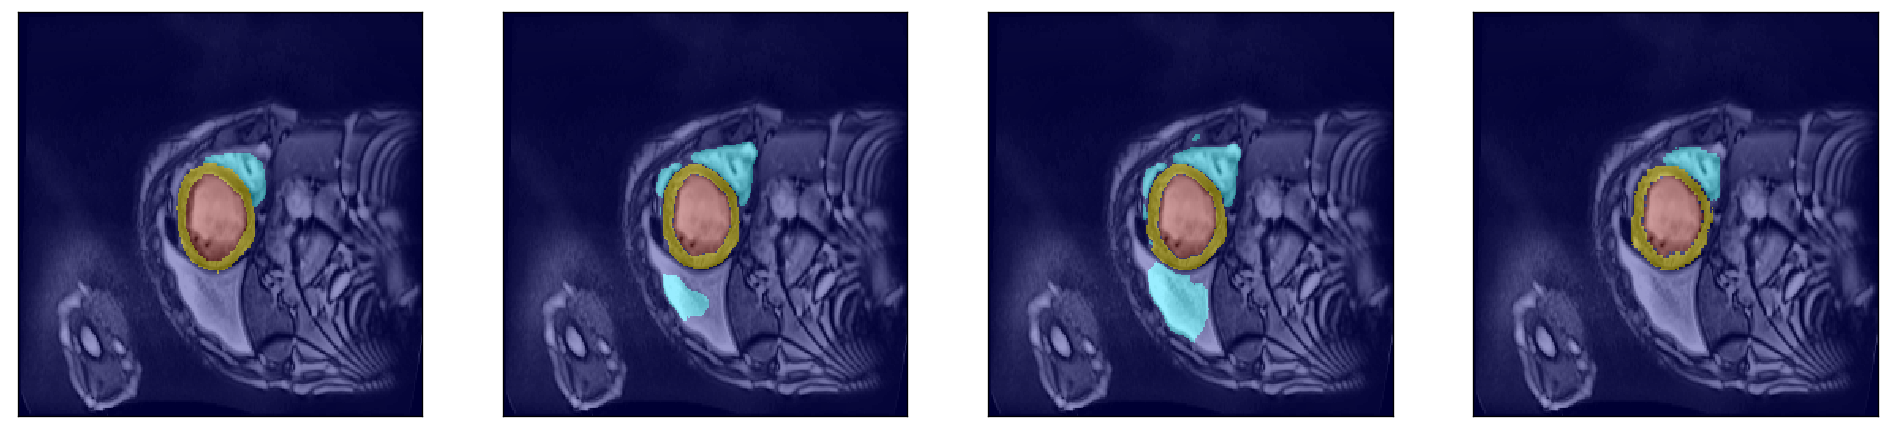

In [51]:
c, img, mask = val_dataset[35]
fig, ax = plt.subplots(figsize=(20,10), dpi=120, ncols=4)

ax[0].imshow(img.numpy()[0], cmap=plt.cm.gray)
ax[0].imshow(mask.numpy()[0], alpha=0.4, cmap=plt.cm.jet)
ax[0].set_xticks([])
ax[0].set_yticks([])

for i, model in enumerate([unet_rn50, unet_dn161, enet]):
    plot_pred(model, img, ax[i+1])
plt.show()